In [2]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from tensorflow.keras import backend as clear
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [3]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [10]:
df = pd.read_csv('TSM_5year.csv')
df

,Date,Close
0,2018/6/11,38.759998
1,2018/6/12,39.200001
2,2018/6/13,39.049999
3,2018/6/14,38.599998
4,2018/6/15,38.689999
...,...,...
1253,2023/6/2,98.940002
1254,2023/6/5,98.050003
1255,2023/6/6,99.820000
1256,2023/6/7,100.290001


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Close   1258 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


In [12]:
df.describe()

,Close
count,1258.000000
mean,76.969412
std,30.716491
min,34.360001
25%,44.629999
50%,79.930000
75%,105.032498
max,140.660004


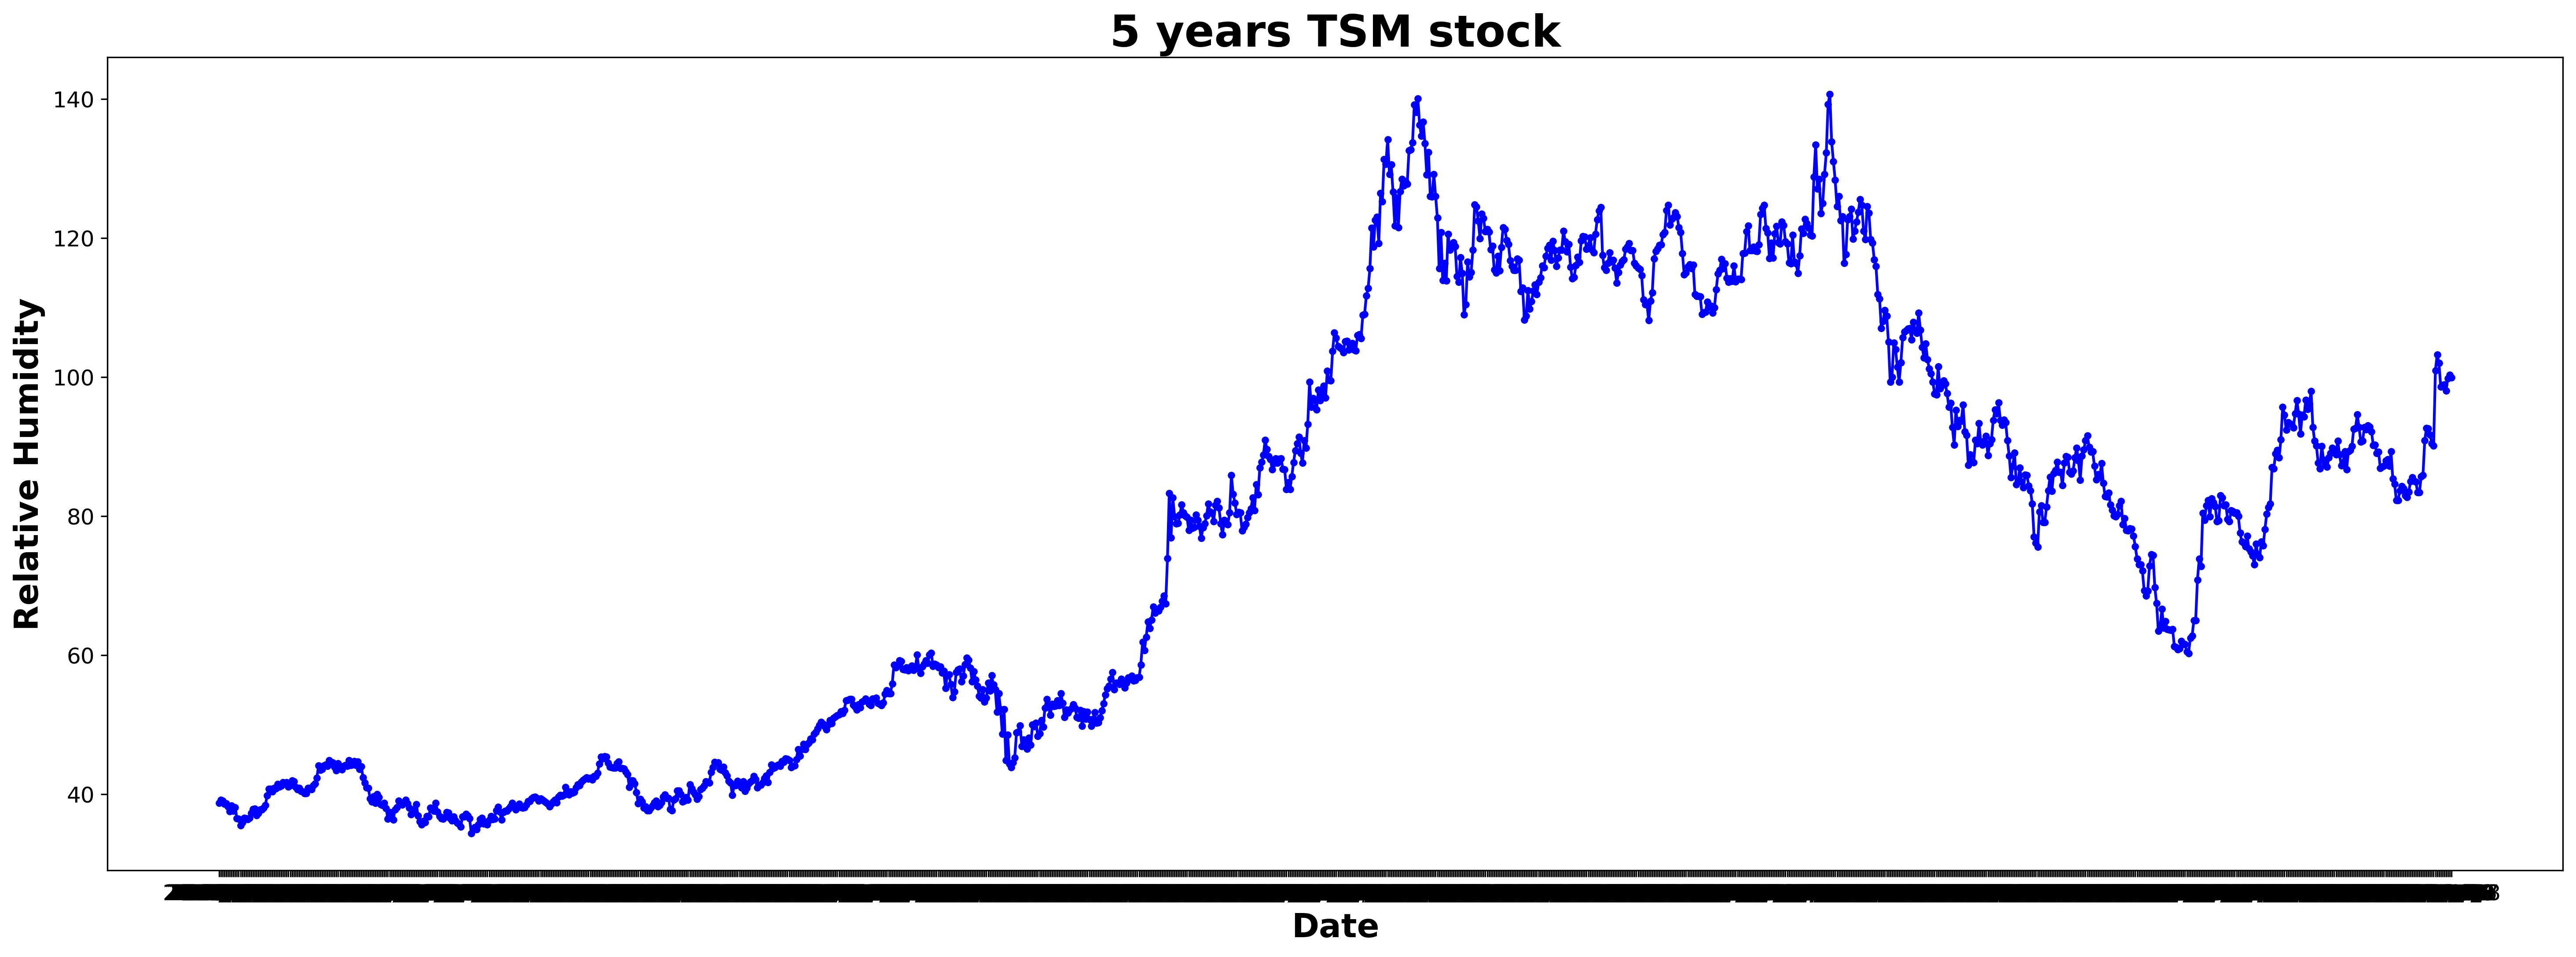

In [13]:
plt.figure(figsize=(24,8),dpi=300)
plt.title('5 years TSM stock',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(df['Date'],df['Close'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [14]:
df['Lag_1']=df['Close'].shift(1).copy()
df['Lag_2']=df['Close'].shift(2).copy()
df['Lag_3']=df['Close'].shift(3).copy()
df.head()

,Date,Close,Lag_1,Lag_2,Lag_3
0,2018/6/11,38.759998,NaN,NaN,NaN
1,2018/6/12,39.200001,38.759998,NaN,NaN
2,2018/6/13,39.049999,39.200001,38.759998,NaN
3,2018/6/14,38.599998,39.049999,39.200001,38.759998
4,2018/6/15,38.689999,38.599998,39.049999,39.200001


In [15]:
clean_df=df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,2018/6/14,38.599998,39.049999,39.200001,38.759998
1,2018/6/15,38.689999,38.599998,39.049999,39.200001
2,2018/6/18,38.250000,38.689999,38.599998,39.049999
3,2018/6/19,37.560001,38.250000,38.689999,38.599998
4,2018/6/20,38.349998,37.560001,38.250000,38.689999
...,...,...,...,...,...
1250,2023/6/2,98.940002,98.839996,98.589996,101.980003
1251,2023/6/5,98.050003,98.940002,98.839996,98.589996
1252,2023/6/6,99.820000,98.050003,98.940002,98.839996
1253,2023/6/7,100.290001,99.820000,98.050003,98.940002


In [16]:
Forecast_train_data=clean_df.iloc[0:213,:].copy()
Forecast_train_data

,Date,Close,Lag_1,Lag_2,Lag_3
0,2018/6/14,38.599998,39.049999,39.200001,38.759998
1,2018/6/15,38.689999,38.599998,39.049999,39.200001
2,2018/6/18,38.250000,38.689999,38.599998,39.049999
3,2018/6/19,37.560001,38.250000,38.689999,38.599998
4,2018/6/20,38.349998,37.560001,38.250000,38.689999
...,...,...,...,...,...
208,2019/4/12,42.580002,42.099998,42.369999,42.209999
209,2019/4/15,42.610001,42.580002,42.099998,42.369999
210,2019/4/16,43.009998,42.610001,42.580002,42.099998
211,2019/4/17,44.389999,43.009998,42.610001,42.580002


In [17]:
Forecast_test_data=clean_df.iloc[213:213+36,:].copy()
Forecast_test_data

,Date,Close,Lag_1,Lag_2,Lag_3
213,2019/4/22,45.150002,45.400002,44.389999,43.009998
214,2019/4/23,45.419998,45.150002,45.400002,44.389999
215,2019/4/24,45.410000,45.419998,45.150002,45.400002
216,2019/4/25,44.480000,45.410000,45.419998,45.150002
217,2019/4/26,43.939999,44.480000,45.410000,45.419998
218,2019/4/29,43.830002,43.939999,44.480000,45.410000
219,2019/4/30,43.820000,43.830002,43.939999,44.480000
220,2019/5/1,43.820000,43.820000,43.830002,43.939999
221,2019/5/2,44.400002,43.820000,43.820000,43.830002
222,2019/5/3,44.709999,44.400002,43.820000,43.820000


In [18]:
# Expanding 1
Exp_training_1=Forecast_train_data.iloc[0:105,:].copy()
Exp_val_1=Forecast_train_data.iloc[105:105+36,:].copy()

# Expanding 2
Exp_training_2=Forecast_train_data.iloc[0:141,:].copy()
Exp_val_2=Forecast_train_data.iloc[141:141+36,:].copy()

# Expanding 3
Exp_training_3=Forecast_train_data.iloc[0:177,:].copy()
Exp_val_3=Forecast_train_data.iloc[177:177+36,:].copy()

In [19]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:105,:].copy()
Rol_val_1=Forecast_train_data.iloc[105:105+36,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[33:141,:].copy()
Rol_val_2=Forecast_train_data.iloc[141:141+36,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[69:177,:].copy()
Rol_val_3=Forecast_train_data.iloc[177:177+36,:].copy()

In [20]:
#set x (make prediction)
# Train
x_train=Exp_training_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_3['Close'].copy()
y_val=Exp_val_3['Close'].copy()

In [21]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Close'].copy()
y_val=Rol_val_1['Close'].copy()

In [22]:
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.377399,0.393390,0.346482
1,0.329424,0.377399,0.393390
2,0.339019,0.329424,0.377399
3,0.292111,0.339019,0.329424
4,0.218550,0.292111,0.339019


In [23]:
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


In [24]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from tensorflow.keras.saving import get_custom_objects #for colab version problem
from keras.utils.__init__ import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

In [168]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.002,beta_1=0.95)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________


In [169]:
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
2/2 [==============================] - 1s 187ms/step - loss: 40.3072 - mean_absolute_percentage_error: 99.8291 - val_loss: 36.6413 - val_mean_absolute_percentage_error: 99.7683
Epoch 2/300
2/2 [==============================] - 0s 43ms/step - loss: 40.2608 - mean_absolute_percentage_error: 99.7144 - val_loss: 36.5985 - val_mean_absolute_percentage_error: 99.6516
Epoch 3/300
2/2 [==============================] - 0s 37ms/step - loss: 40.2114 - mean_absolute_percentage_error: 99.5930 - val_loss: 36.5526 - val_mean_absolute_percentage_error: 99.5263
Epoch 4/300
2/2 [==============================] - 0s 34ms/step - loss: 40.1590 - mean_absolute_percentage_error: 99.4637 - val_loss: 36.5041 - val_mean_absolute_percentage_error: 99.3938
Epoch 5/300
2/2 [==============================] - 0s 31ms/step - loss: 40.1028 - mean_absolute_percentage_error: 99.3257 - val_loss: 36.4528 - val_mean_absolute_percentage_error: 99.2539
Epoch 6/300
2/2 [==============================] - 0s 34ms/

In [170]:
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

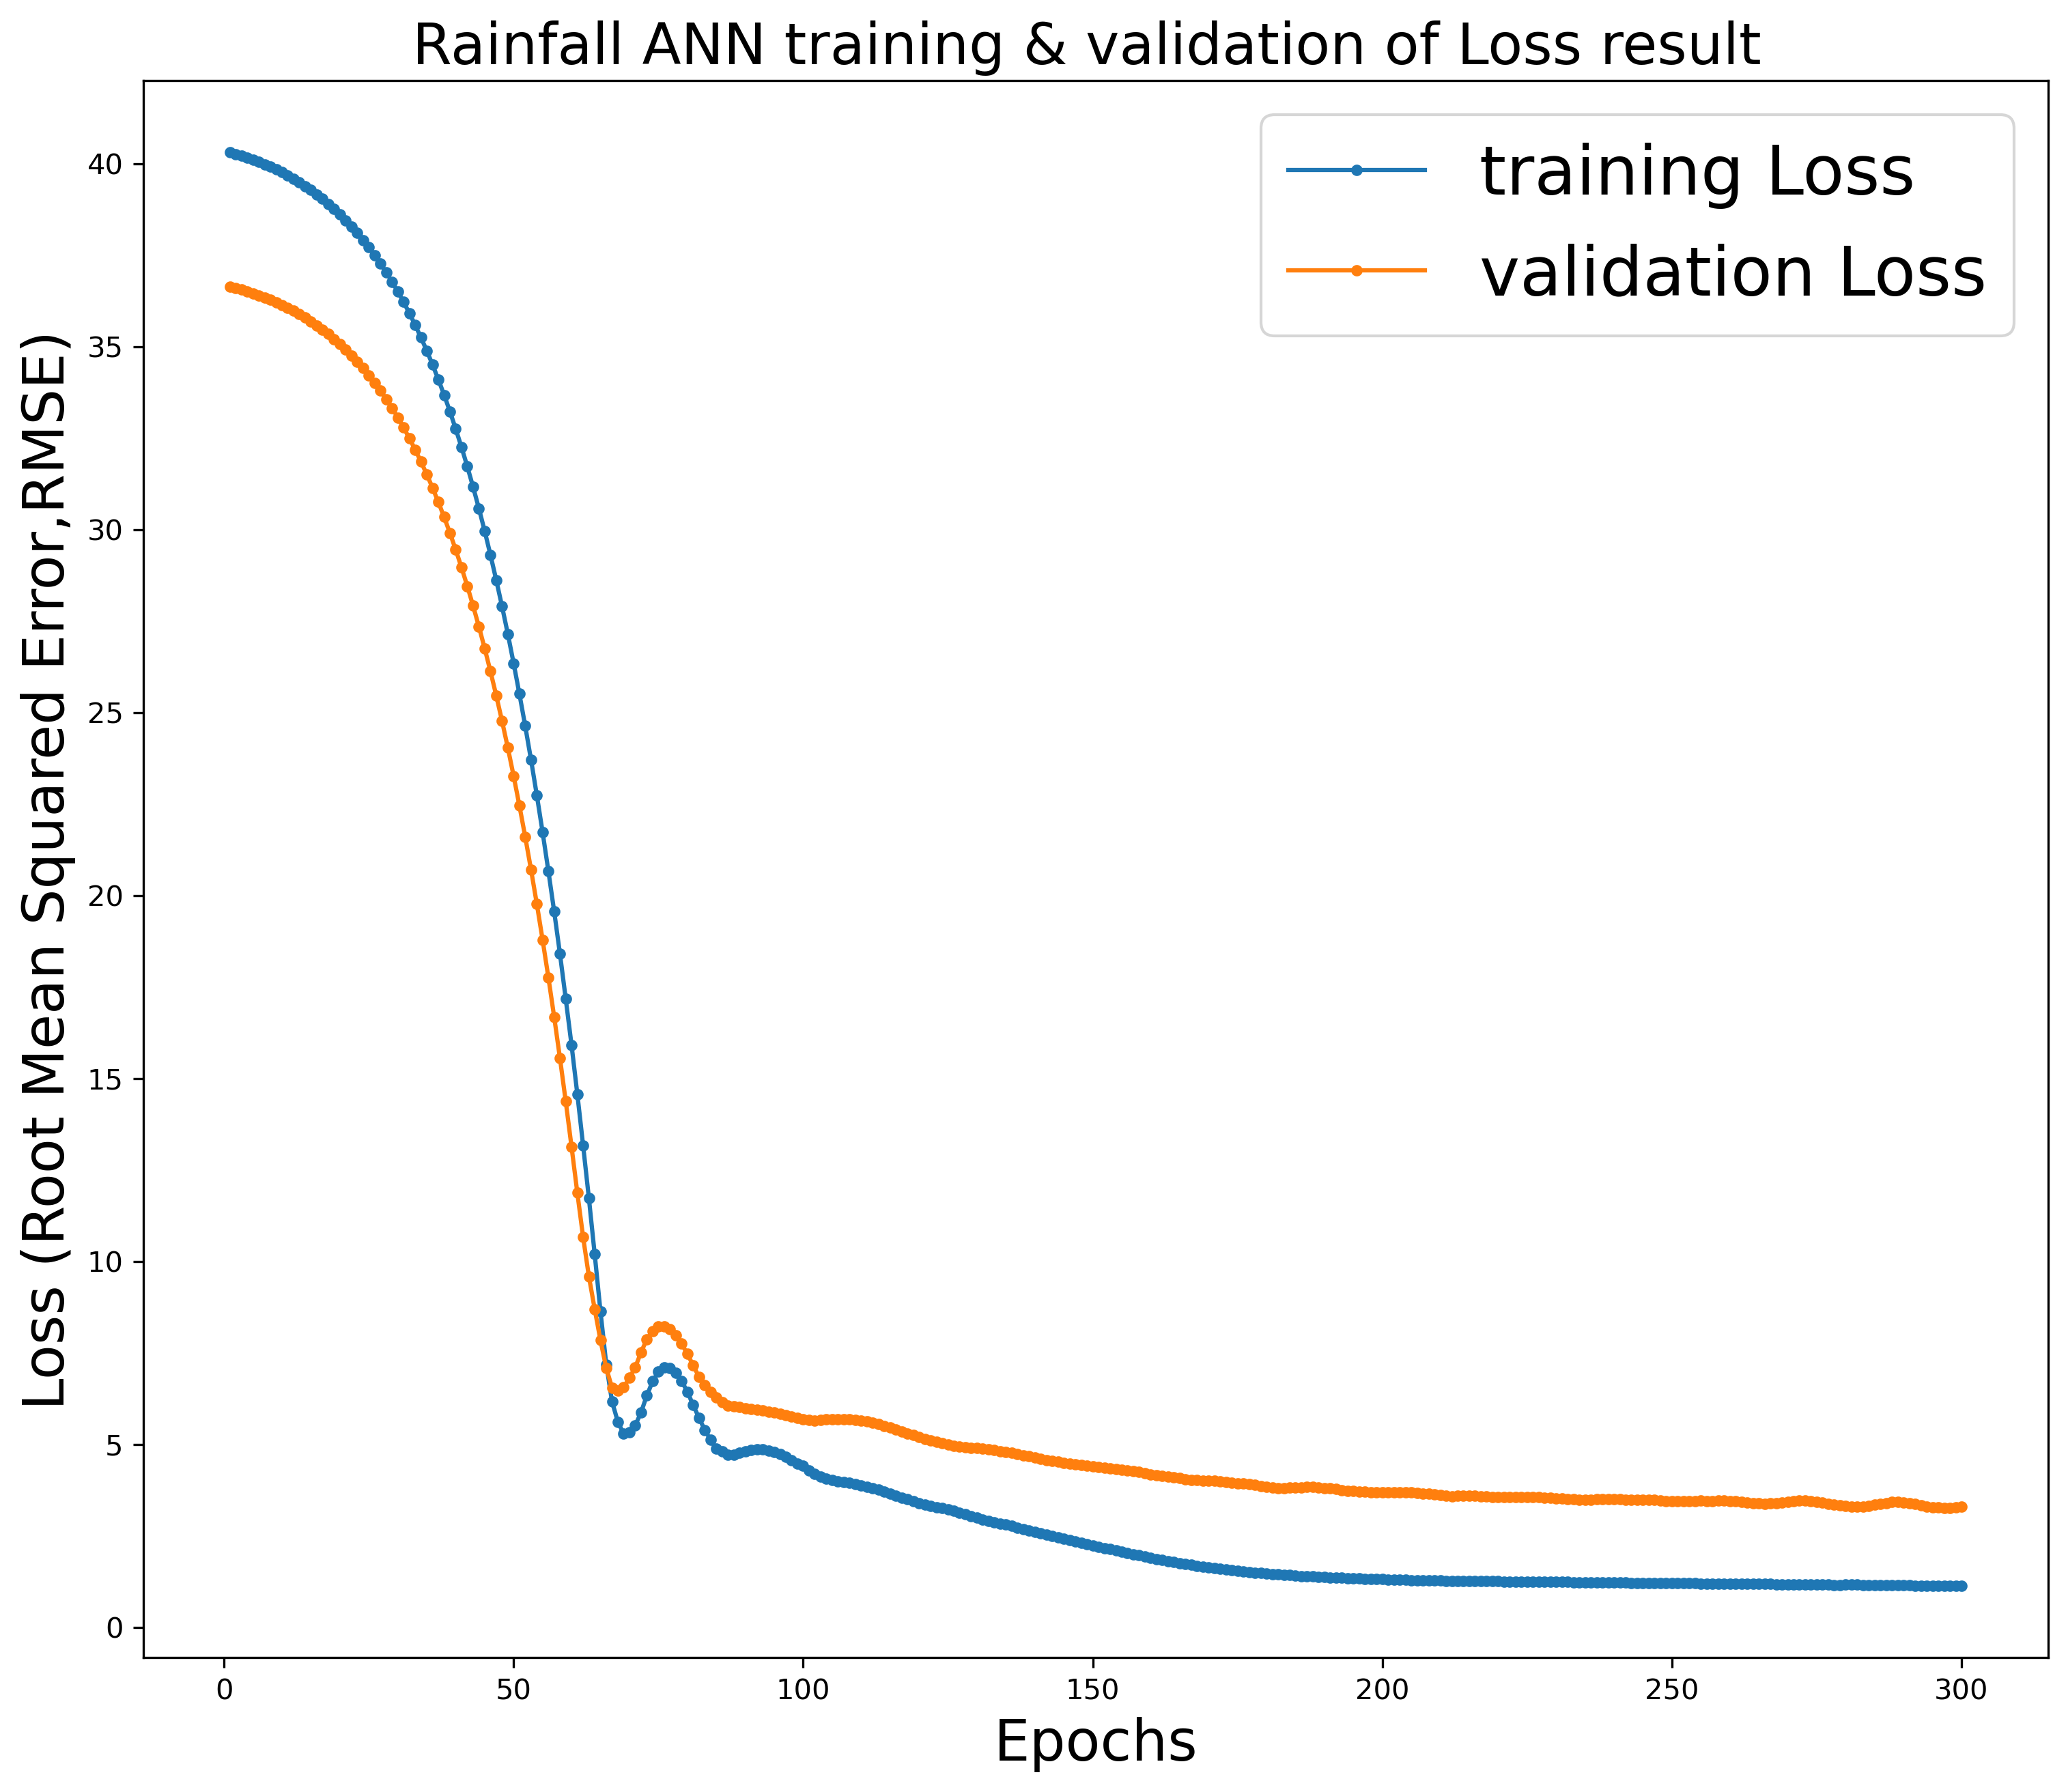

In [171]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

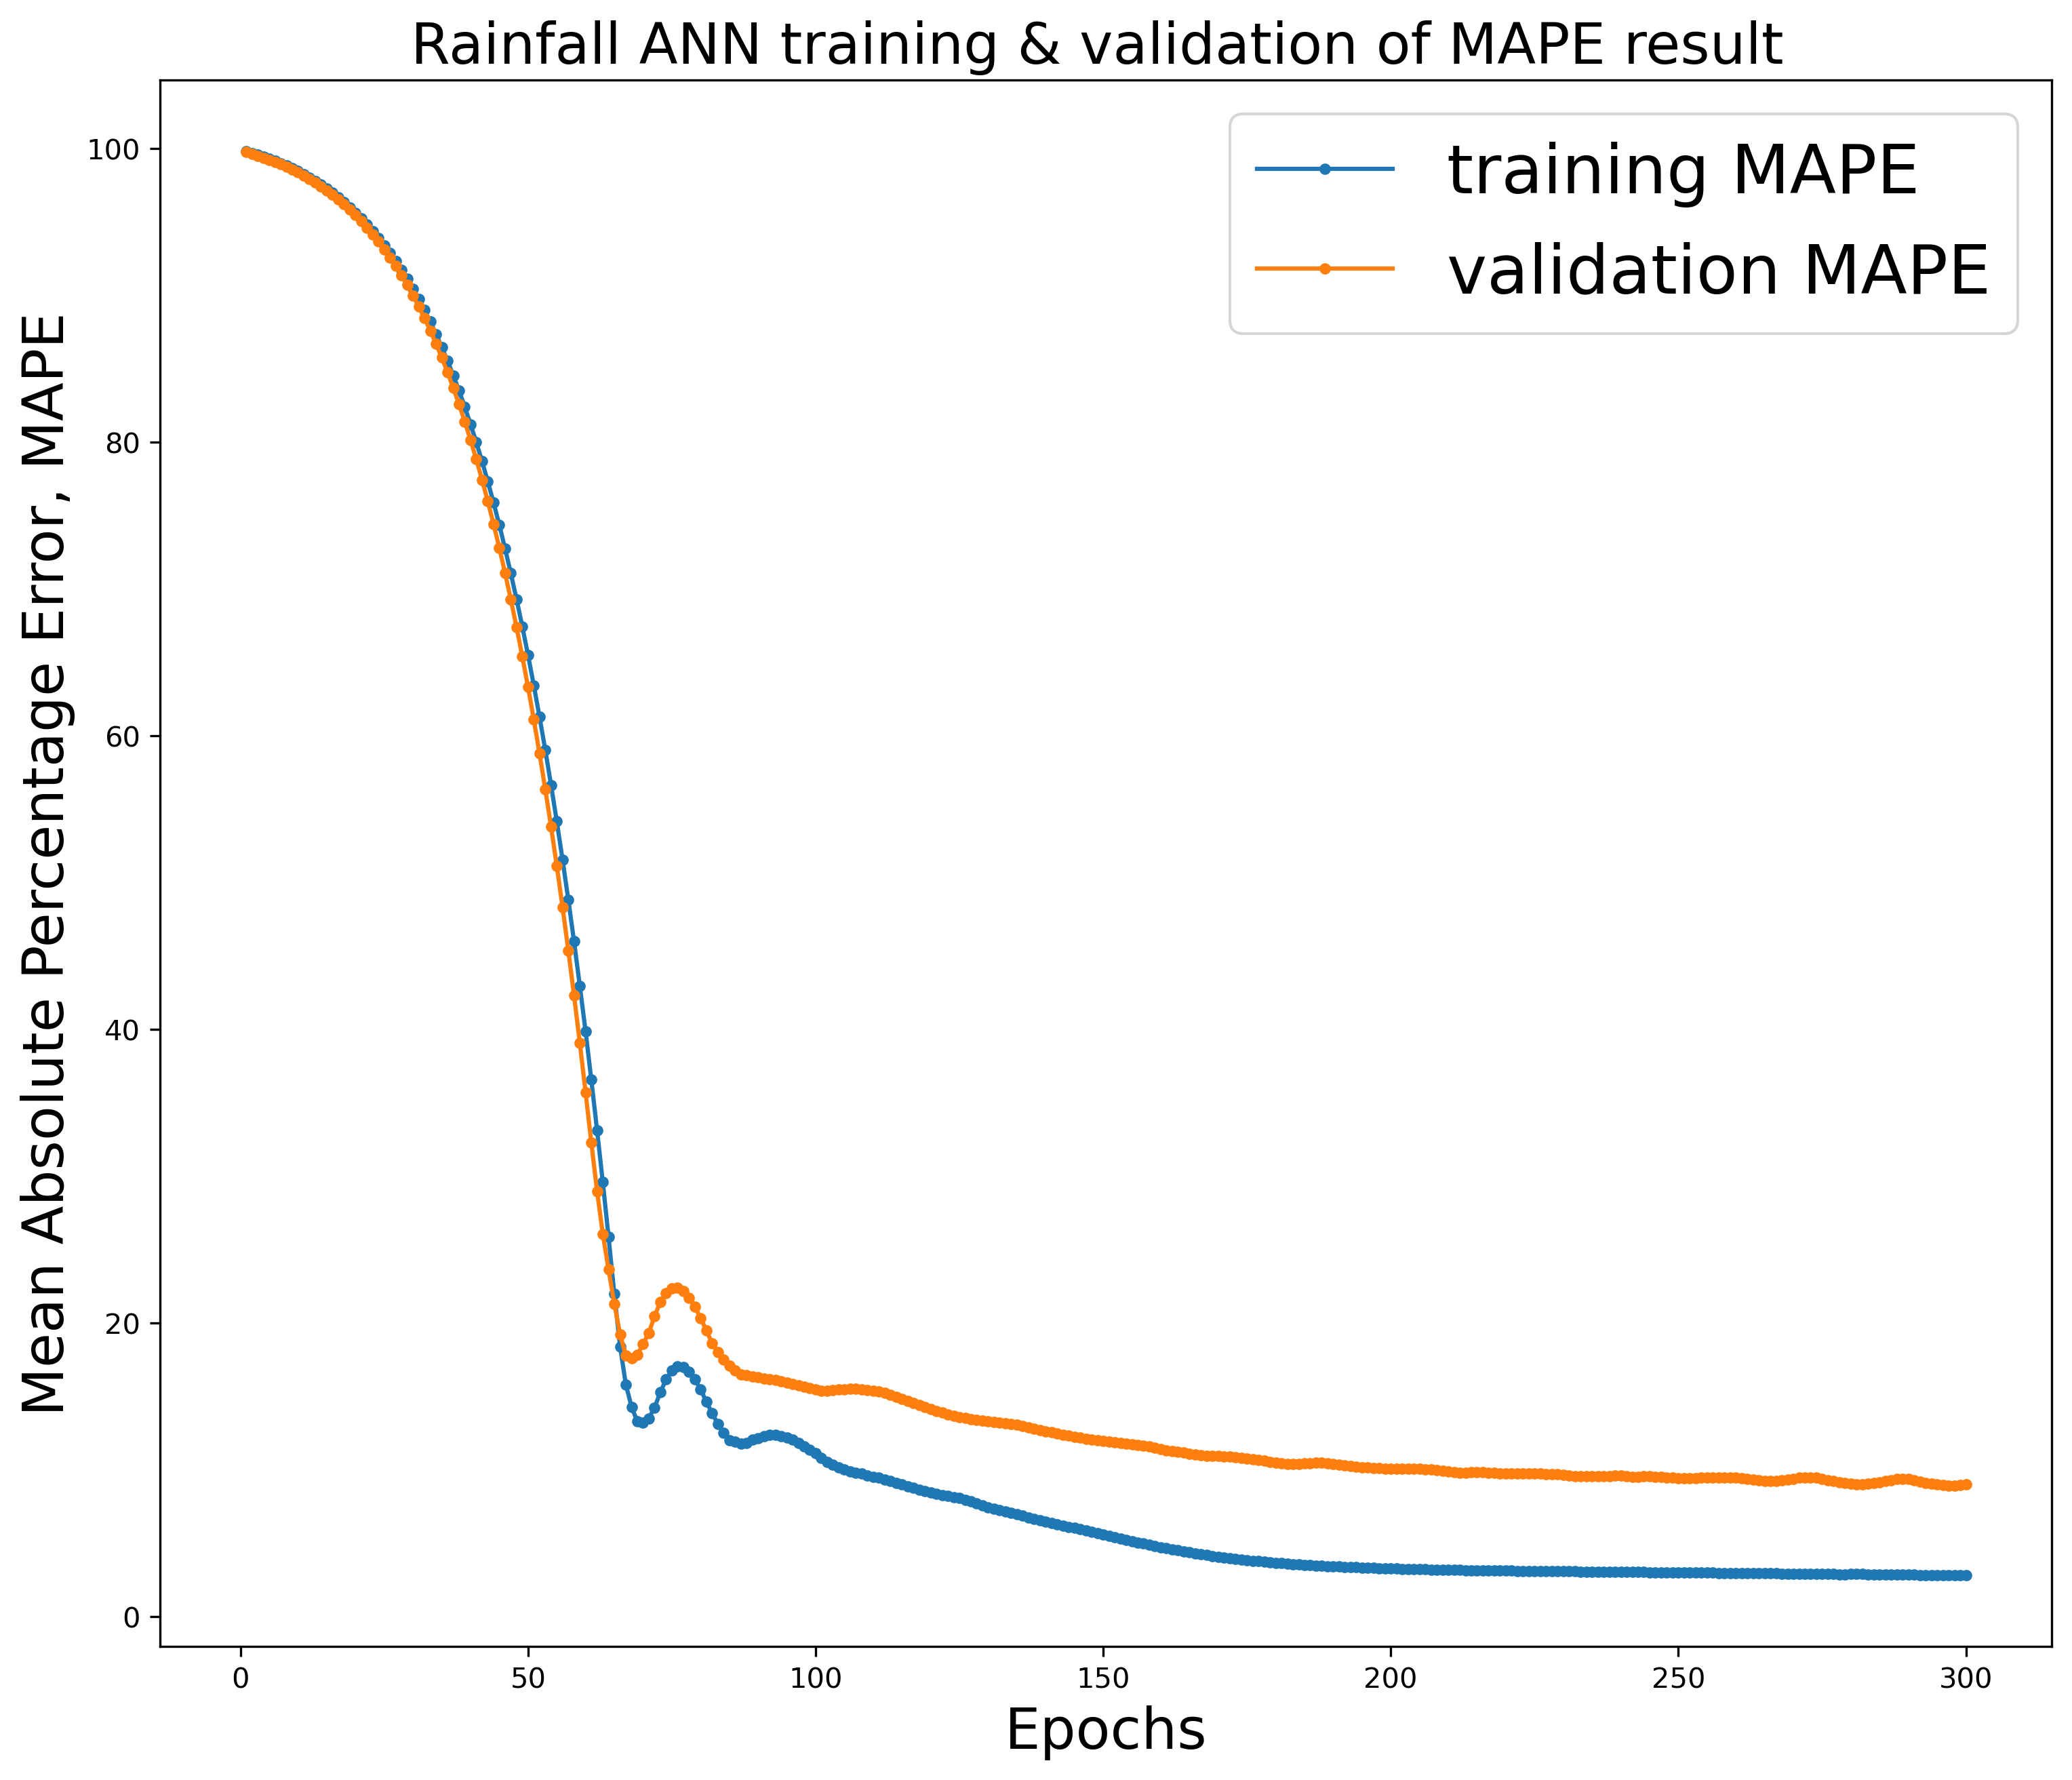

In [172]:
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

In [173]:
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [174]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))

# Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.002,beta_1=0.95)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________


In [175]:
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=64,verbose=1)

Epoch 1/300
4/4 [==============================] - 1s 3ms/step - loss: 20.7579 - mean_absolute_percentage_error: 52.7259
Epoch 2/300
4/4 [==============================] - 0s 2ms/step - loss: 11.9114 - mean_absolute_percentage_error: 30.2337
Epoch 3/300
4/4 [==============================] - 0s 2ms/step - loss: 2.9155 - mean_absolute_percentage_error: 7.3780
Epoch 4/300
4/4 [==============================] - 0s 3ms/step - loss: 5.1087 - mean_absolute_percentage_error: 13.0153
Epoch 5/300
4/4 [==============================] - 0s 2ms/step - loss: 6.4680 - mean_absolute_percentage_error: 16.4778
Epoch 6/300
4/4 [==============================] - 0s 2ms/step - loss: 4.0555 - mean_absolute_percentage_error: 10.3378
Epoch 7/300
4/4 [==============================] - 0s 2ms/step - loss: 1.0617 - mean_absolute_percentage_error: 2.7166
Epoch 8/300
4/4 [==============================] - 0s 2ms/step - loss: 3.2352 - mean_absolute_percentage_error: 8.2060
Epoch 9/300
4/4 [========================

In [176]:
Fmodel.save('/Users/weiziyao/Desktop/作業/Rainfall_forecast_ANN_trained_model.h5')

print('Model has been saved...')

Model has been saved...


In [177]:
ANN_model=keras.models.load_model('/Users/weiziyao/Desktop/作業/Rainfall_forecast_ANN_trained_model.h5')
# Colab
#ANN_model=keras.models.load_model('')
print('Model successfully loaded...')

Model successfully loaded...


In [178]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Close'].copy()

In [179]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [180]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Close_true':Forecast_test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Close_true']-Results['Predict'])
Results

,Date,Close_true,Predict,abs Error
213,2019/4/22,45.150002,45.619999,4.699969e-01
214,2019/4/23,45.419998,45.639999,2.200014e-01
215,2019/4/24,45.410000,45.630001,2.200011e-01
216,2019/4/25,44.480000,45.750000,1.270000e+00
217,2019/4/26,43.939999,45.020000,1.080001e+00
218,2019/4/29,43.830002,44.270000,4.399985e-01
219,2019/4/30,43.820000,44.099998,2.799985e-01
220,2019/5/1,43.820000,44.119999,2.999989e-01
221,2019/5/2,44.400002,44.130001,2.700009e-01
222,2019/5/3,44.709999,44.560001,1.499976e-01


In [181]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 0.606
MSE: 0.685
RMSE: 0.828
MAPE: 1.478 %
SMAPE: 1.459 %
RAE: 0.246
MRAE: 0.006833266670908474
MdRAE: 0.144 bench: 41.3
RSE: 0.097
RRSE: 0.312


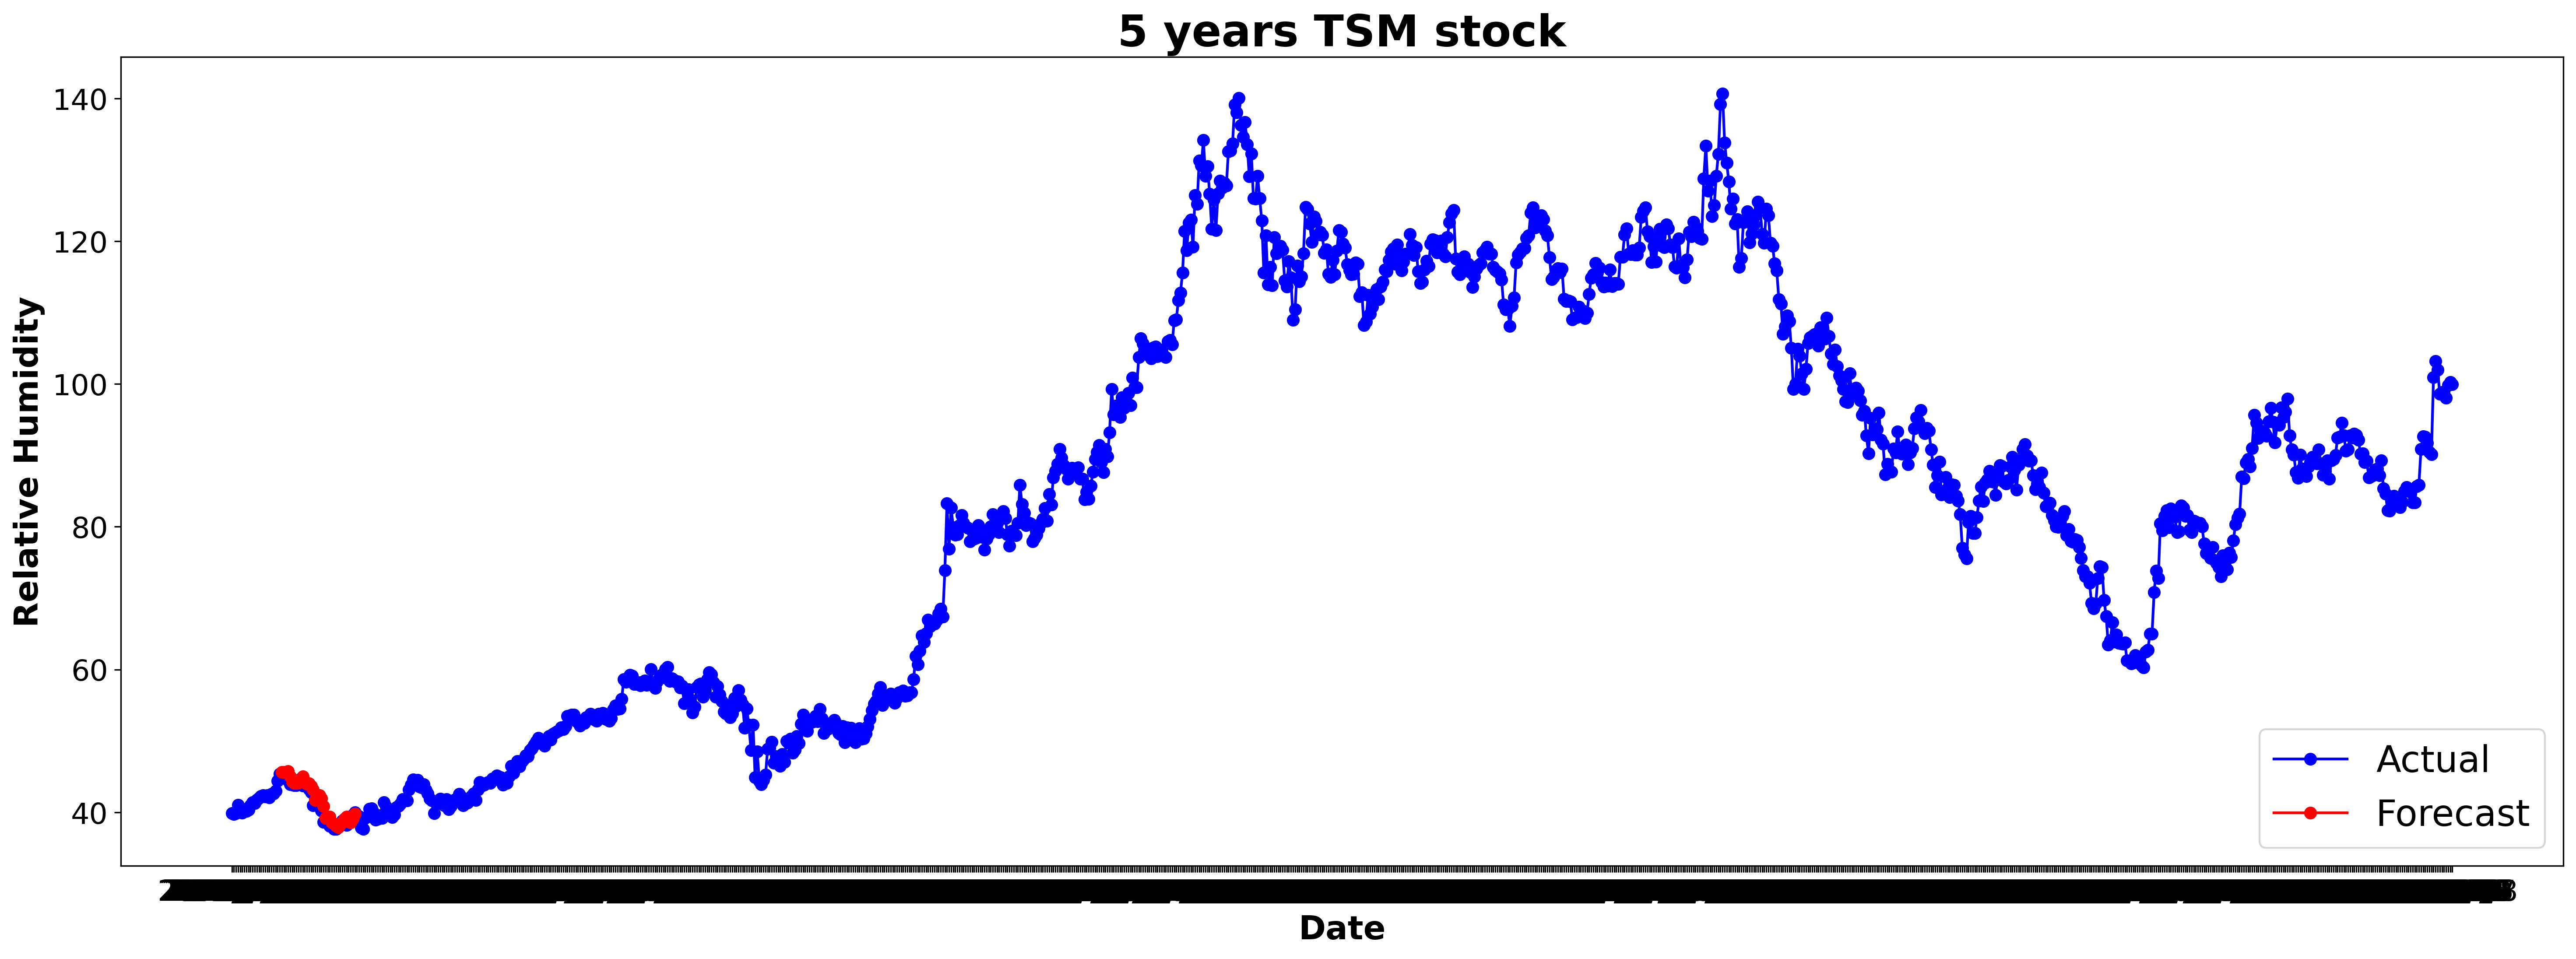

In [182]:
plt.figure(figsize=(24,8),dpi=300)
plt.title('5 years TSM stock',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[189:,0],clean_df.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

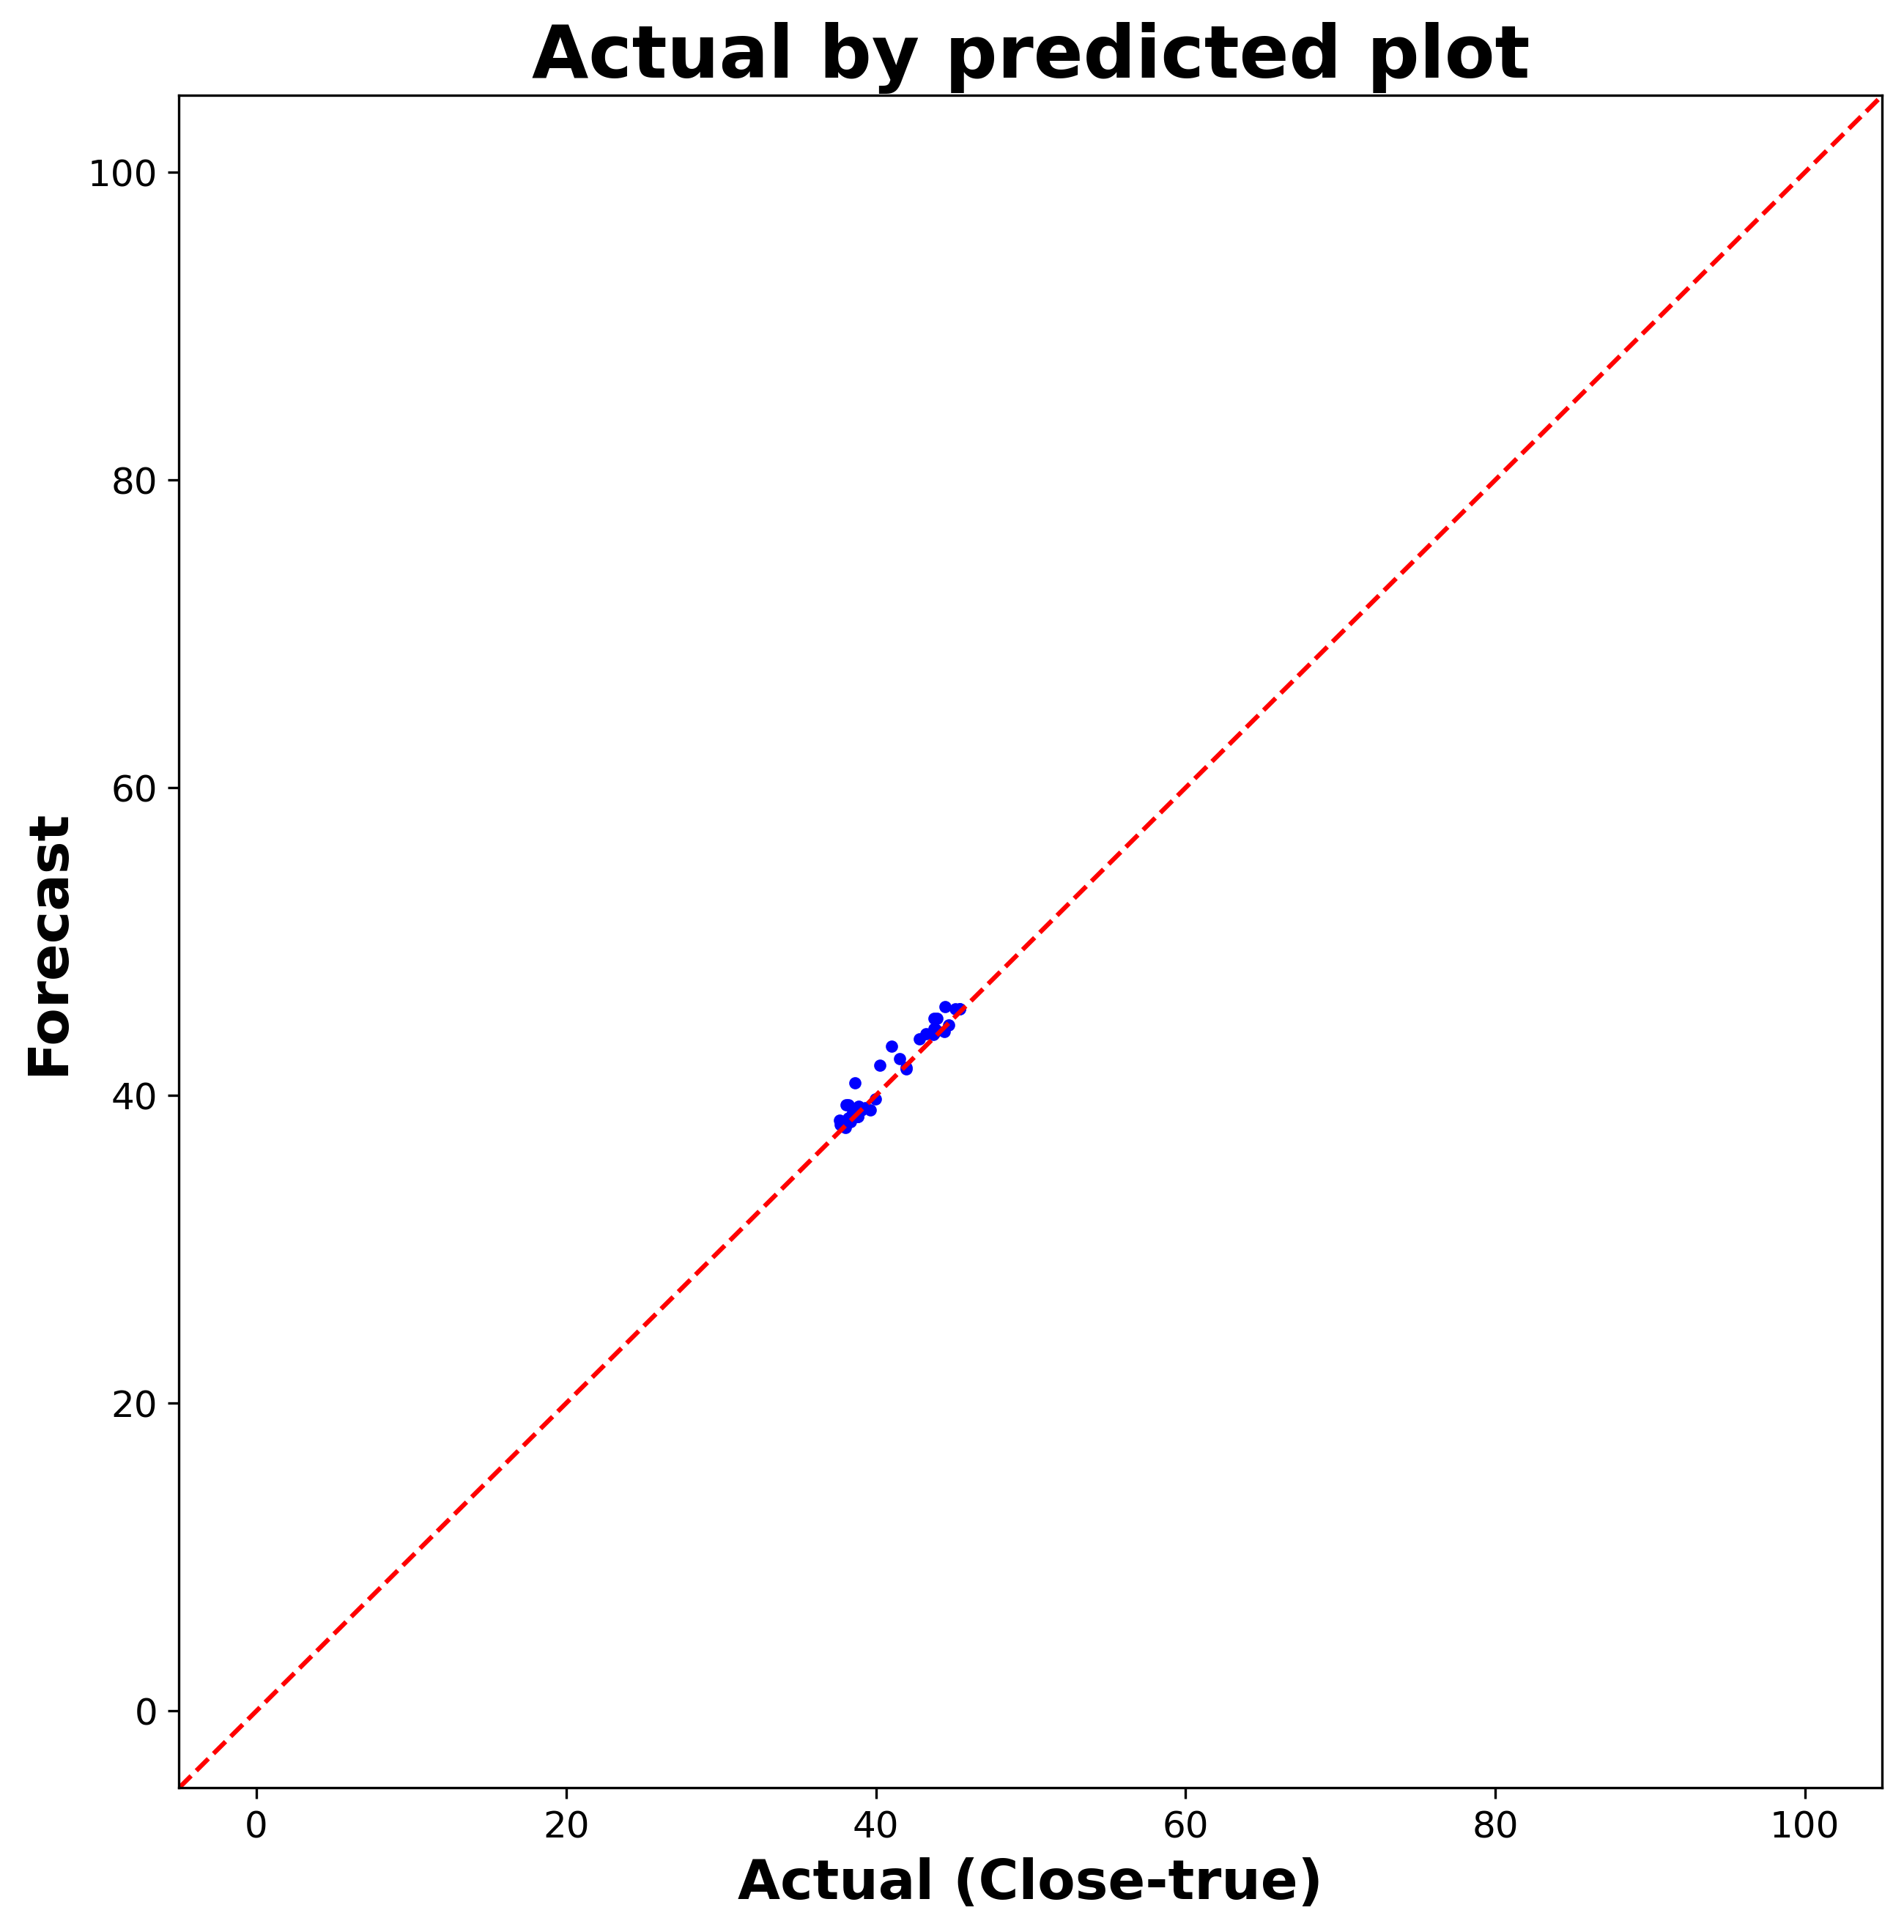

In [183]:
# Lock the scale of axis by Y_true
max_value=100+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Close-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()